## Augmentation에 의한 모델 성능 비교

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [2]:
import tensorflow as tf
import numpy as np

2025-02-27 21:37:32.407395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 21:37:33.363838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 데이터셋 불러오기

* stanford_dogs 데이터셋을 사용
* 120개의 견종으로 라벨링 되어 있음
* 총 20,580장 이미지 : train - 12,000장 / test - 8,580장

해당 내용대로 불러왔으며 train 중 80%를 학습데이터로 20%를 검증데이터로 사용했습니다

2025-02-27 21:37:42.566129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 21:37:42.652827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 21:37:42.652885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 21:37:42.656850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 21:37:42.656894: I tensorflow/compile

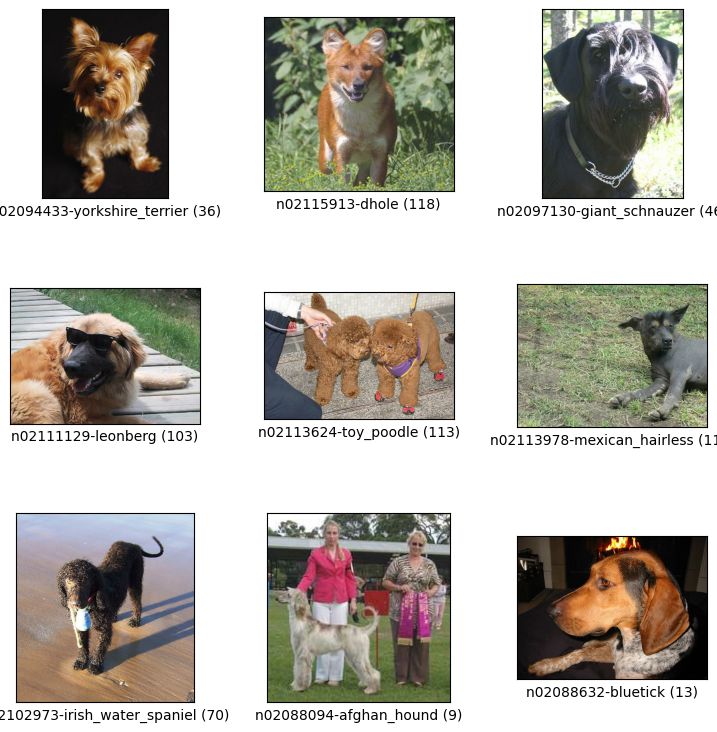

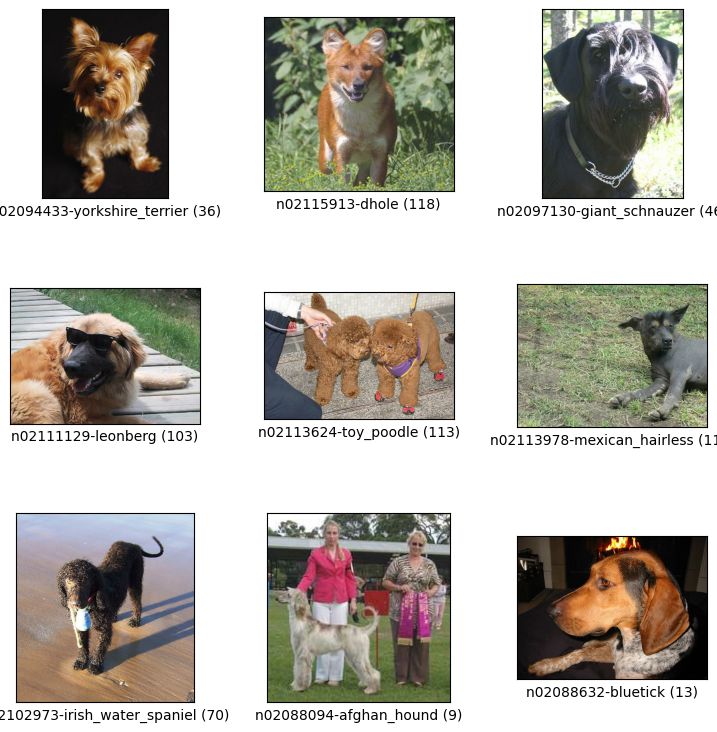

In [3]:
import tensorflow_datasets as tfds

# 데이터 로드 및 train을 80%:20%로 나누어 train/valid 생성
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    with_info=True,
)

# 샘플 이미지 확인 
tfds.show_examples(ds_train, ds_info)


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_valid))
print(tf.data.experimental.cardinality(ds_test))

num_classes = ds_info.features["label"].num_classes

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})
tf.Tensor(9600, shape=(), dtype=int64)
tf.Tensor(2400, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


### CutMix 구현하기

In [5]:
#bbox 정의
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max, image_size_x, image_size_y

In [6]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max,image_size_x,image_size_y):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def cutmix(image, label, prob=1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max, image_size_x, image_size_y = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x, image_size_y))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup 구현하기

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 전처리 함수 구현 및 데이터셋 적용

In [13]:
def normalize_and_resize_img(example):
    image = example['image']
    label = example['label']
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

#기본 증강
def basic_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.cast(label, tf.int32)  # label을 int32로 변환
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_aug:
        ds = ds.map(
            basic_augment
        )
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [33]:
BATCH_SIZE = 16

DS_with_noaug_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
DS_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE, is_test=True)
DS_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

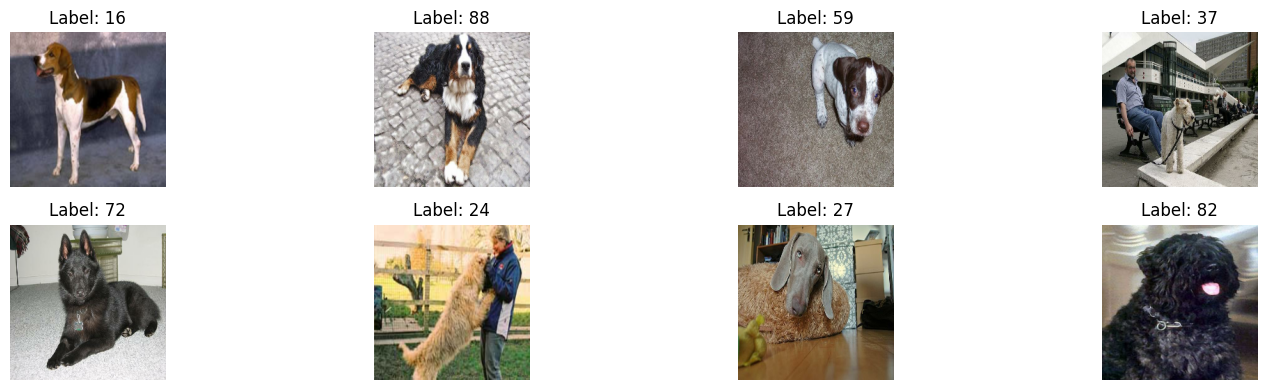

Label of first image in the batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 배치 하나를 추출
for images, labels in DS_with_noaug_train.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)-8): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()
    # 배치의 첫 번째 이미지에 해당하는 레이블만 한 번 출력
    print("Label of first image in the batch: ", labels[0].numpy())  # 첫 번째 이미지의 레이블만 출력


In [35]:
DS_with_aug_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)

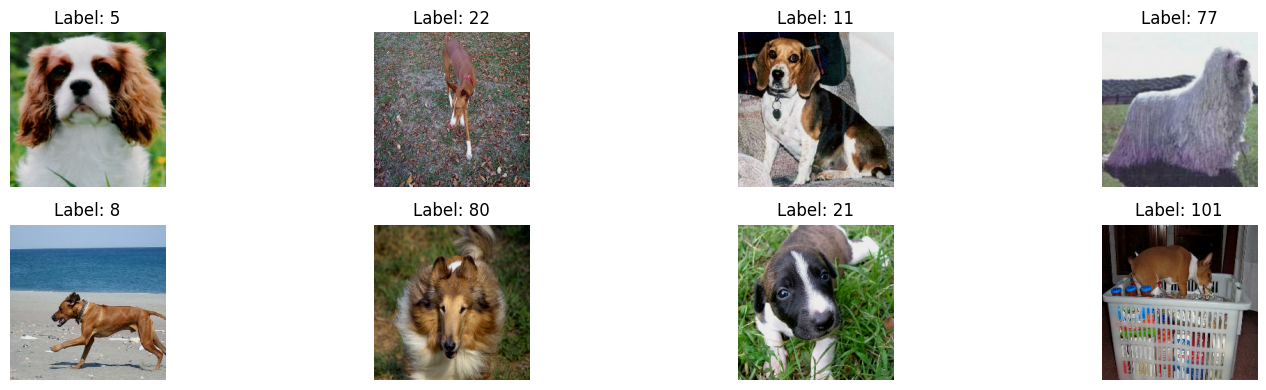

In [36]:
# 배치 하나를 추출
for images, labels in DS_with_aug_train.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)-8): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()


In [37]:
DS_with_aug_cutmix_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True, with_cutmix=True)

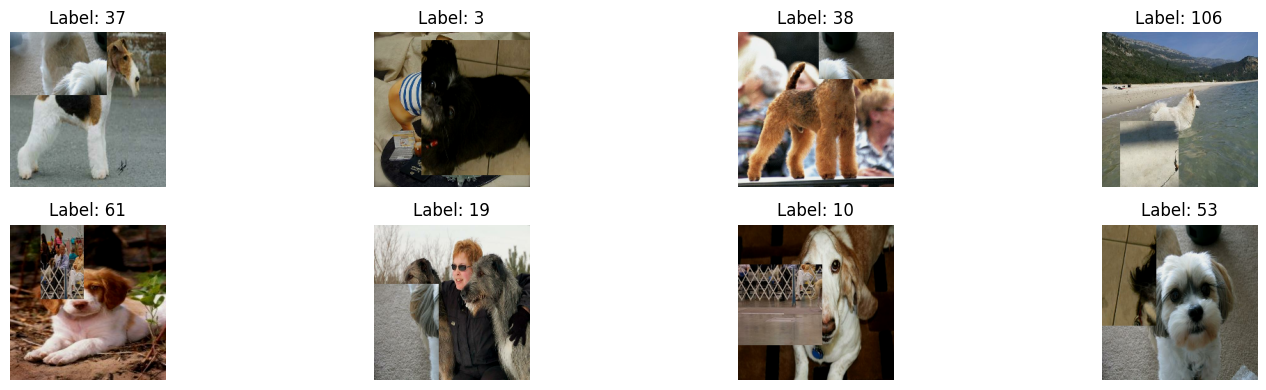

Label of first image in the batch:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.7451371  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.25486287
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

In [38]:
# 배치 하나를 추출
for images, labels in DS_with_aug_cutmix_train.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)-8): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()
    # 배치의 첫 번째 이미지에 해당하는 레이블만 한 번 출력
    print("Label of first image in the batch: ", labels[0].numpy())  # 첫 번째 이미지의 레이블만 출력

In [39]:
DS_with_aug_mixup_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True, with_mixup=True)

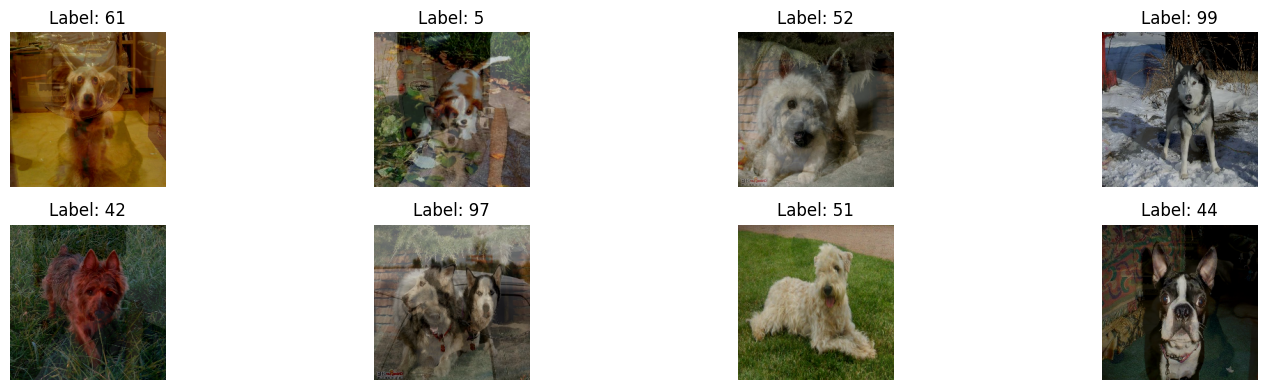

Label of first image in the batch:  [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4071591 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.5928409 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0. 

In [40]:
# 배치 하나를 추출
for images, labels in DS_with_aug_mixup_train.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)-8): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()
    # 배치의 첫 번째 이미지에 해당하는 레이블만 한 번 출력
    print("Label of first image in the batch: ", labels[0].numpy())  # 첫 번째 이미지의 레이블만 출력


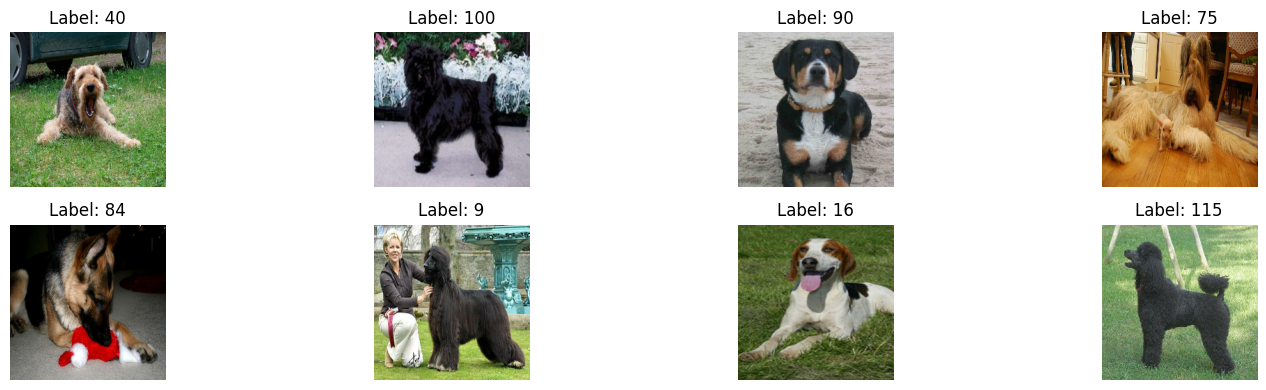

Label of first image in the batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [41]:
# 배치 하나를 추출
for images, labels in DS_test.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)-8): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()
    # 배치의 첫 번째 이미지에 해당하는 레이블만 한 번 출력
    print("Label of first image in the batch: ", labels[0].numpy())  # 첫 번째 이미지의 레이블만 출력


### 모델 만들기

In [42]:
import keras

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [44]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "./best_model_ResNet50_noaug_120dog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

history_resnet50_no_aug = resnet50.fit(
    DS_with_noaug_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/16),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/16),
    epochs=EPOCH,
    validation_data=DS_valid,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/20
600/600 [==============================] - ETA: 0s - loss: 2.3382 - accuracy: 0.4345
Epoch 1: val_accuracy improved from -inf to 0.02958, saving model to ./best_model_ResNet50_noaug_120dog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 81s 120ms/step - loss: 2.3382 - accuracy: 0.4345 - val_loss: 4.7206 - val_accuracy: 0.0296
Epoch 2/20
600/600 [==============================] - ETA: 0s - loss: 0.7721 - accuracy: 0.7904
Epoch 2: val_accuracy improved from 0.02958 to 0.63625, saving model to ./best_model_ResNet50_noaug_120dog.h5
600/600 [==============================] - 72s 120ms/step - loss: 0.7721 - accuracy: 0.7904 - val_loss: 1.2210 - val_accuracy: 0.6363
Epoch 3/20
600/600 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9341
Epoch 3: val_accuracy improved from 0.63625 to 0.67042, saving model to ./best_model_ResNet50_noaug_120dog.h5
600/600 [==============================] - 72s 120ms/step - loss: 0.2922 - accuracy: 0.9341 - val_loss: 1.0603 - val_accuracy: 0.6704
Epoch 4/20
600/600 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9884
Epoch 4: val_accuracy improved from 0.67042 to 0.69208, saving model to ./best_model_ResNe

In [46]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    DS_with_aug_train, # augmentation만 적용한 데이터셋
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/16),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/16),
    epochs=EPOCH,
    validation_data=DS_valid,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/20
600/600 [==============================] - ETA: 0s - loss: 2.4303 - accuracy: 0.4090
Epoch 1: val_accuracy did not improve from 0.71583
600/600 [==============================] - 84s 122ms/step - loss: 2.4303 - accuracy: 0.4090 - val_loss: 4.3789 - val_accuracy: 0.0679
Epoch 2/20
600/600 [==============================] - ETA: 0s - loss: 0.9912 - accuracy: 0.7233
Epoch 2: val_accuracy did not improve from 0.71583
600/600 [==============================] - 73s 122ms/step - loss: 0.9912 - accuracy: 0.7233 - val_loss: 1.2531 - val_accuracy: 0.6288
Epoch 3/20
600/600 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.8612
Epoch 3: val_accuracy did not improve from 0.71583
600/600 [==============================] - 74s 124ms/step - loss: 0.5269 - accuracy: 0.8612 - val_loss: 1.1908 - val_accuracy: 0.6592
Epoch 4/20
600/600 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9312
Epoch 4: val_accuracy did not improve from 0.71583
600/600 [=

/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 75s 125ms/step - loss: 0.0497 - accuracy: 0.9939 - val_loss: 1.0098 - val_accuracy: 0.7163
Epoch 8/20
600/600 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9928
Epoch 8: val_accuracy did not improve from 0.71625
600/600 [==============================] - 73s 122ms/step - loss: 0.0566 - accuracy: 0.9928 - val_loss: 1.0851 - val_accuracy: 0.7000
Epoch 9/20
600/600 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9954
Epoch 9: val_accuracy improved from 0.71625 to 0.72000, saving model to ./best_model_ResNet50_noaug_120dog.h5
600/600 [==============================] - 73s 122ms/step - loss: 0.0406 - accuracy: 0.9954 - val_loss: 1.0145 - val_accuracy: 0.7200
Epoch 10/20
600/600 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9981
Epoch 10: val_accuracy improved from 0.72000 to 0.72292, saving model to ./best_model_ResNet50_noaug_120dog.h5
600/600 [============================

In [48]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    DS_with_aug_cutmix_train, # augmentation, cutmix 적용한 데이터셋
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/16),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/16),
    epochs=EPOCH,
    validation_data=DS_valid,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/20
600/600 [==============================] - ETA: 0s - loss: 3.9543 - accuracy: 0.1851
Epoch 1: val_accuracy did not improve from 0.73417
600/600 [==============================] - 86s 123ms/step - loss: 3.9543 - accuracy: 0.1851 - val_loss: 4.7537 - val_accuracy: 0.0275
Epoch 2/20
600/600 [==============================] - ETA: 0s - loss: 3.0560 - accuracy: 0.4003
Epoch 2: val_accuracy did not improve from 0.73417
600/600 [==============================] - 73s 122ms/step - loss: 3.0560 - accuracy: 0.4003 - val_loss: 1.6363 - val_accuracy: 0.5483
Epoch 3/20
600/600 [==============================] - ETA: 0s - loss: 2.7760 - accuracy: 0.4790
Epoch 3: val_accuracy did not improve from 0.73417
600/600 [==============================] - 72s 119ms/step - loss: 2.7760 - accuracy: 0.4790 - val_loss: 1.4091 - val_accuracy: 0.5967
Epoch 4/20
600/600 [==============================] - ETA: 0s - loss: 2.5891 - accuracy: 0.5476
Epoch 4: val_accuracy did not improve from 0.73417
600/600 [=

In [50]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    DS_with_aug_mixup_train, # augmentation만 적용한 데이터셋
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/16),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/16),
    epochs=EPOCH,
    validation_data=DS_valid,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/20
600/600 [==============================] - ETA: 0s - loss: 3.8486 - accuracy: 0.2079
Epoch 1: val_accuracy did not improve from 0.73417
600/600 [==============================] - 84s 114ms/step - loss: 3.8486 - accuracy: 0.2079 - val_loss: 5.1957 - val_accuracy: 0.0079
Epoch 2/20
600/600 [==============================] - ETA: 0s - loss: 2.9929 - accuracy: 0.4320
Epoch 2: val_accuracy did not improve from 0.73417
600/600 [==============================] - 68s 114ms/step - loss: 2.9929 - accuracy: 0.4320 - val_loss: 1.6262 - val_accuracy: 0.5383
Epoch 3/20
600/600 [==============================] - ETA: 0s - loss: 2.7126 - accuracy: 0.5269
Epoch 3: val_accuracy did not improve from 0.73417
600/600 [==============================] - 69s 114ms/step - loss: 2.7126 - accuracy: 0.5269 - val_loss: 1.4930 - val_accuracy: 0.5904
Epoch 4/20
600/600 [==============================] - ETA: 0s - loss: 2.5531 - accuracy: 0.5894
Epoch 4: val_accuracy did not improve from 0.73417
600/600 [=

In [53]:
import json

# 학습 로그 저장
with open("./history_noaug_ResNet50.json", "w") as f:
    json.dump(history_resnet50_no_aug.history, f)

with open("./history_aug_ResNet50.json", "w") as f:
    json.dump(history_resnet50_aug.history, f)

with open("./history_aug_cutmix_ResNet50.json", "w") as f:
    json.dump(history_resnet50_aug_cutmix.history, f)

with open("./history_aug_mixup_ResNet50.json", "w") as f:
    json.dump(history_resnet50_aug_mixup.history, f)


In [68]:
# 가장 높은 val_accuracy를 기록한 epoch 찾기
best_epoch = np.argmax(history_resnet50_no_aug.history['val_accuracy']) + 1
print(f"Best epoch: {best_epoch}")

# 해당 epoch의 가중치 저장
resnet50.save(f"best_model_ResNet50_noaug_120dog.h5")
print("✅ 최적 모델 저장 완료!")

Best epoch: 15
✅ 최적 모델 저장 완료!


In [69]:
# 가장 높은 val_accuracy를 기록한 epoch 찾기
best_epoch = np.argmax(history_resnet50_aug.history['val_accuracy']) + 1
print(f"Best epoch: {best_epoch}")

# 해당 epoch의 가중치 저장
aug_resnet50.save(f"best_model_ResNet50_aug_120dog.h5")
print("✅ 최적 모델 저장 완료!")

Best epoch: 19
✅ 최적 모델 저장 완료!


In [70]:
# 가장 높은 val_accuracy를 기록한 epoch 찾기
best_epoch = np.argmax(history_resnet50_aug_cutmix.history['val_accuracy']) + 1
print(f"Best epoch: {best_epoch}")

# 해당 epoch의 가중치 저장
aug_cutmix_resnet50.save(f"best_model_ResNet50_aug_cutmix_120dog.h5")
print("✅ 최적 모델 저장 완료!")

Best epoch: 8
✅ 최적 모델 저장 완료!


In [71]:
# 가장 높은 val_accuracy를 기록한 epoch 찾기
best_epoch = np.argmax(history_resnet50_aug_mixup.history['val_accuracy']) + 1
print(f"Best epoch: {best_epoch}")

# 해당 epoch의 가중치 저장
aug_mixup_resnet50.save(f"best_model_ResNet50_aug_mixup_120dog.h5")
print("✅ 최적 모델 저장 완료!")

Best epoch: 16
✅ 최적 모델 저장 완료!


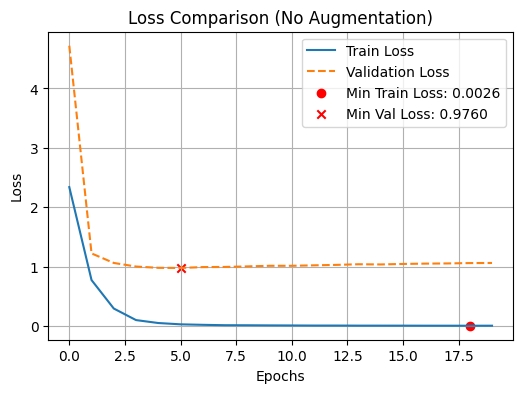

📉 No Augmentation - Min Train Loss: 0.0026 at Epoch 18
📉 No Augmentation - Min Val Loss: 0.9760 at Epoch 5



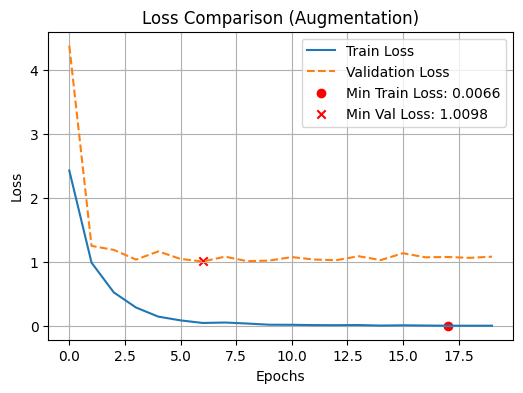

📉 Augmentation - Min Train Loss: 0.0066 at Epoch 17
📉 Augmentation - Min Val Loss: 1.0098 at Epoch 6



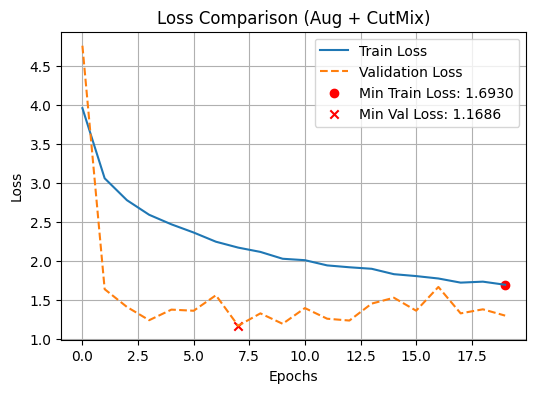

📉 Aug + CutMix - Min Train Loss: 1.6930 at Epoch 19
📉 Aug + CutMix - Min Val Loss: 1.1686 at Epoch 7



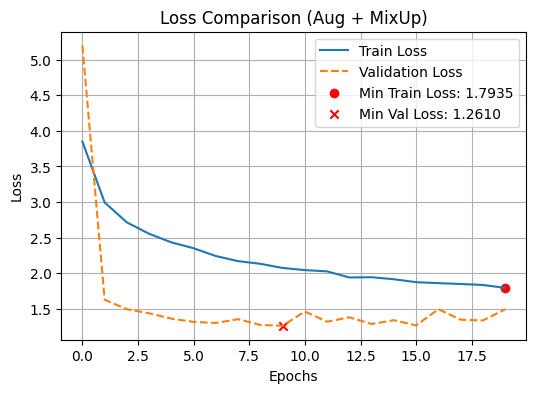

📉 Aug + MixUp - Min Train Loss: 1.7935 at Epoch 19
📉 Aug + MixUp - Min Val Loss: 1.2610 at Epoch 9



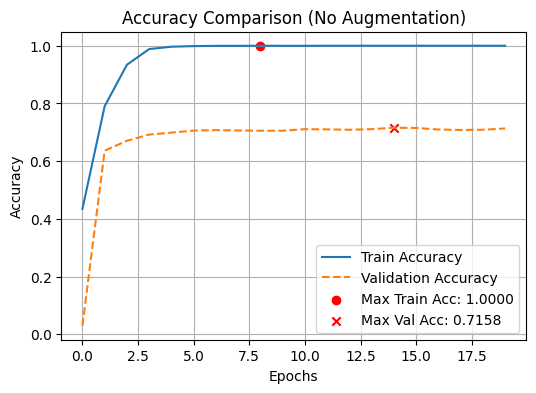

📈 No Augmentation - Max Train Accuracy: 1.0000 at Epoch 8
📈 No Augmentation - Max Val Accuracy: 0.7158 at Epoch 14



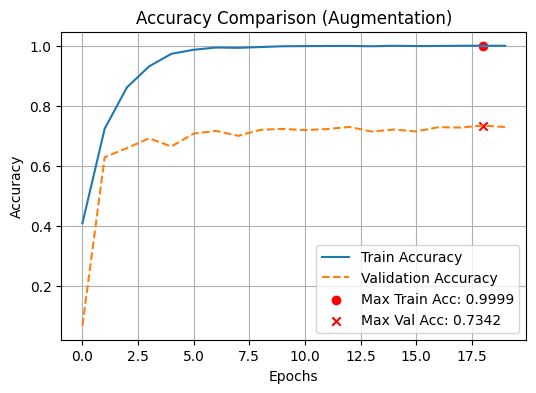

📈 Augmentation - Max Train Accuracy: 0.9999 at Epoch 18
📈 Augmentation - Max Val Accuracy: 0.7342 at Epoch 18



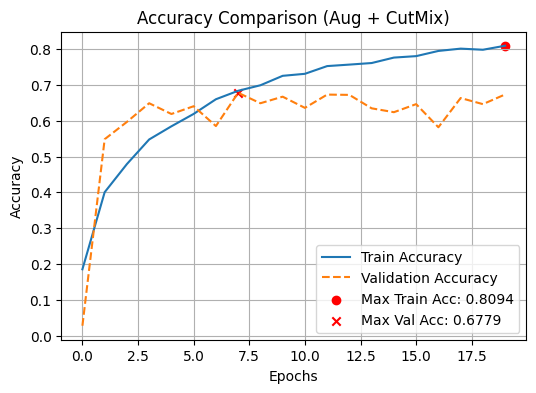

📈 Aug + CutMix - Max Train Accuracy: 0.8094 at Epoch 19
📈 Aug + CutMix - Max Val Accuracy: 0.6779 at Epoch 7



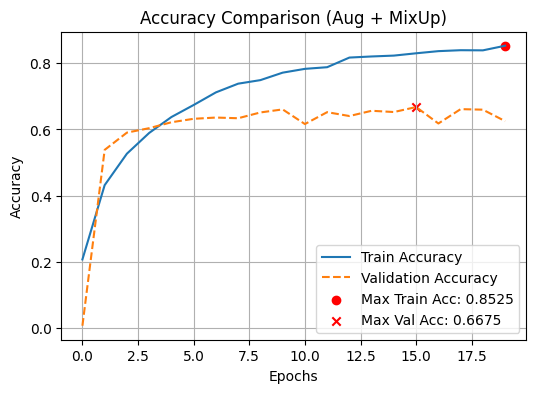

📈 Aug + MixUp - Max Train Accuracy: 0.8525 at Epoch 19
📈 Aug + MixUp - Max Val Accuracy: 0.6675 at Epoch 15


📊 Training & Validation Performance Summary
          Model  Min Train Loss  Epoch (Train Loss)  Min Val Loss  Epoch (Val Loss)  Max Train Accuracy  Epoch (Train Acc)  Max Val Accuracy  Epoch (Val Acc)
No Augmentation        0.002627                  18      0.975986                 5            1.000000                  8          0.715833               14
   Augmentation        0.006636                  17      1.009814                 6            0.999896                 18          0.734167               18
   Aug + CutMix        1.693042                  19      1.168597                 7            0.809375                 19          0.677917                7
    Aug + MixUp        1.793460                  19      1.261041                 9            0.852500                 19          0.667500               15


In [61]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# 📂 JSON 파일 리스트
history_files = {
    "No Augmentation": "./history_noaug_ResNet50.json",
    "Augmentation": "./history_aug_ResNet50.json",
    "Aug + CutMix": "./history_aug_cutmix_ResNet50.json",
    "Aug + MixUp": "./history_aug_mixup_ResNet50.json",
}

# 결과를 저장할 리스트
results = []

# 🔹 1) 모델별 Loss 그래프 (최저 Loss 표시)
for label, file in history_files.items():
    with open(file, "r") as f:
        history = json.load(f)

    # 최저 Loss 찾기
    min_train_loss = min(history["loss"])
    min_train_epoch = history["loss"].index(min_train_loss)
    min_val_loss = min(history["val_loss"])
    min_val_epoch = history["val_loss"].index(min_val_loss)

    # 그래프 그리기
    plt.figure(figsize=(6, 4))
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], linestyle="dashed", label="Validation Loss")

    # 최저 Loss 지점 표시 (빨간 점)
    plt.scatter(min_train_epoch, min_train_loss, color="red", marker="o", label=f"Min Train Loss: {min_train_loss:.4f}")
    plt.scatter(min_val_epoch, min_val_loss, color="red", marker="x", label=f"Min Val Loss: {min_val_loss:.4f}")

    plt.title(f"Loss Comparison ({label})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    results.append({
        "Model": label,
        "Min Train Loss": min_train_loss,
        "Epoch (Train Loss)": min_train_epoch,
        "Min Val Loss": min_val_loss,
        "Epoch (Val Loss)": min_val_epoch,
        "Max Train Accuracy": None,
        "Epoch (Train Acc)": None,
        "Max Val Accuracy": None,
        "Epoch (Val Acc)": None
    })

    # 🔽 최저 Loss 출력
    print(f"📉 {label} - Min Train Loss: {min_train_loss:.4f} at Epoch {min_train_epoch}")
    print(f"📉 {label} - Min Val Loss: {min_val_loss:.4f} at Epoch {min_val_epoch}\n")

# 🔹 2) 모델별 Accuracy 그래프 (최고 Accuracy 표시)
for label, file in history_files.items():
    with open(file, "r") as f:
        history = json.load(f)

    # 최고 Accuracy 찾기
    max_train_acc = max(history["accuracy"])
    max_train_epoch = history["accuracy"].index(max_train_acc)
    max_val_acc = max(history["val_accuracy"])
    max_val_epoch = history["val_accuracy"].index(max_val_acc)

    # 그래프 그리기
    plt.figure(figsize=(6, 4))
    plt.plot(history["accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], linestyle="dashed", label="Validation Accuracy")

    # 최고 Accuracy 지점 표시 (빨간 점)
    plt.scatter(max_train_epoch, max_train_acc, color="red", marker="o", label=f"Max Train Acc: {max_train_acc:.4f}")
    plt.scatter(max_val_epoch, max_val_acc, color="red", marker="x", label=f"Max Val Acc: {max_val_acc:.4f}")

    plt.title(f"Accuracy Comparison ({label})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # results 리스트에서 해당 모델 데이터 찾기
    for result in results:
        if result["Model"] == label:
            result["Max Train Accuracy"] = max_train_acc
            result["Epoch (Train Acc)"] = max_train_epoch
            result["Max Val Accuracy"] = max_val_acc
            result["Epoch (Val Acc)"] = max_val_epoch
            break

    # 🔽 최고 Accuracy 출력
    print(f"📈 {label} - Max Train Accuracy: {max_train_acc:.4f} at Epoch {max_train_epoch}")
    print(f"📈 {label} - Max Val Accuracy: {max_val_acc:.4f} at Epoch {max_val_epoch}\n")

# 📋 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)

# 📌 표 형태로 출력
print("\n📊 Training & Validation Performance Summary")
print(df_results.to_string(index=False))


최종 결과를 확인하기 전(Inference 해보기 전), 정리하자면 아래와 같다
1. CutMix , Mixup, basic augmentation, no aug 순으로 Train Accuracy가 낮은 걸 확인할 수 있다 => 이 순서대로 변형이 더 심하다
    * 해당 이유를 더 찾아보면 CutMix의 경우 잘린 부분이 핵심적인 부분인 경우 정답을 맞추기가 굉장히 어려워진다는걸 유추할 수 있다.

2. Validation Accuracy의 경우 기본적인 Augmentation을 진행한 경우만 성능이 좋아졌다
    * 사용된 학습 데이터셋 전부에 augmentation을 적용하는게 좀 무리한 접근일 수 있다고 생각된다.
    * Mixup이나 CutMix의 경우, 완벽히 수렴했다고 20 epoch 만으로 판단하기 어려워 보여, 비교가 성급하다고 생각한다.
    * 학습 데이터셋 일부에 augmentation을 적용한다면 CutMix는 20% Mixup은 30% 일반 augmentation은 40%로 하는게 성능을 더 높일 수 있다고 생각한다.(심한 augmentation일수록 조금만 적용하기)

(최종 예측도 Validation Accuracy에서의 순서와 같은 결과가 나왔다)

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# 모델 불러오기
model_noaug = load_model("best_model_ResNet50_noaug_120dog.h5")
model_aug = load_model("best_model_ResNet50_aug_120dog.h5")
model_aug_cutmix = load_model("best_model_ResNet50_aug_cutmix_120dog.h5")
model_aug_mixup = load_model("best_model_ResNet50_aug_mixup_120dog.h5")

# 배치 크기 설정
BATCH_SIZE = 16

def evaluate_model(model, dataset):
    correct_predictions = 0
    total_predictions = 0

    # 데이터셋에서 배치별로 예측 수행
    for batch, labels in dataset:
        # 모델 예측
        predictions = model.predict(batch, batch_size=BATCH_SIZE)
        
        # 예측값을 확률에서 레이블로 변환
        predicted_labels = np.argmax(predictions, axis=-1)
        
        # 레이블을 정수형으로 변환 (원핫 인코딩 된 경우)
        if len(labels.shape) > 1 and labels.shape[-1] > 1:
            labels = np.argmax(labels, axis=-1)

        # 정확도 계산
        correct_predictions += np.sum(predicted_labels == labels)
        total_predictions += len(labels)
    
    # 전체 데이터에 대한 정확도 계산
    accuracy = correct_predictions / total_predictions
    return accuracy


# 각 모델에 대해 accuracy 측정
accuracy_noaug = evaluate_model(model_noaug, DS_test)
accuracy_aug = evaluate_model(model_aug, DS_test)
accuracy_aug_cutmix = evaluate_model(model_aug_cutmix, DS_test)
accuracy_aug_mixup = evaluate_model(model_aug_mixup, DS_test)

In [76]:
# 출력
print(f"Accuracy (No Augmentation): {accuracy_noaug * 100:.2f}%")
print(f"Accuracy (Augmentation): {accuracy_aug * 100:.2f}%")
print(f"Accuracy (Aug + CutMix): {accuracy_aug_cutmix * 100:.2f}%")
print(f"Accuracy (Aug + MixUp): {accuracy_aug_mixup * 100:.2f}%")

Accuracy (No Augmentation): 73.30%
Accuracy (Augmentation): 74.50%
Accuracy (Aug + CutMix): 69.09%
Accuracy (Aug + MixUp): 64.74%


##### 랜덤 augmentation 적용
각 augmentation 기법들을 분류하여 실험하기에 시간 제약이 있어 지금 구현한 augmentation기법들을 랜덤으로 적용하고 이전 실험과 동일하게 20 epoch 진행 후 Inference 성능을 측정하여 전체를 augmentation하는게 나은지 랜덤하게 적용하는게 나은지 확인해보고자 한다

In [ ]:
#배치 단위로 해당 확률을 통과하면 해당 배치 전체가 적용되는 것으로 확인

def apply_with_probability(image, label, augmentation_fn, prob=0.5):
    """ 일정 확률(prob)로 augmentation_fn을 적용하는 함수 """
    should_apply = tf.random.uniform([]) < prob  # 0~1 사이 랜덤 값 생성하여 확률 비교
    return tf.cond(should_apply, 
                   lambda: augmentation_fn(image, label),  # 0.5보다 증강 적용
                   lambda: (image, label))  # 증강 미적용

def apply_cutmix_or_mixup(image, label, cutmix_fn, mixup_fn, prob=0.5):
    """ 
    1. 50% 확률로 augmentation( cutmix 또는 mixup )을 적용할지 결정하고,
    2. 적용하기로 결정하면, 새로운 난수를 생성해 cutmix와 mixup 중 하나를 동일한 확률로 선택합니다.
    """
    # 1. 적용 여부 결정 (50% 확률)
    should_apply = tf.random.uniform([]) < prob

    def choose_augmentation():
        # 2. 새로운 난수 생성: 이 난수를 기준으로 50% 확률로 cutmix, 50%로 mixup을 적용
        choice = tf.random.uniform([])
        return tf.cond(
            choice < 0.5,
            lambda: cutmix_fn(image, label),
            lambda: mixup_fn(image, label)
        )

    return tf.cond(
        should_apply,
        choose_augmentation,
        lambda: (image, label)
    )



def apply_normalize_on_dataset(ds, is_test=False, batch_size=8, with_augment=True, aug_prob=0.5):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.map(onehot, num_parallel_calls=2)
    ds = ds.batch(batch_size)

    if not is_test and with_augment:
        ds = ds.map(lambda img, lbl: apply_with_probability(img, lbl, basic_augment, aug_prob))
        ds = ds.map(lambda img, lbl: apply_cutmix_or_mixup(img, lbl, cutmix, mixup, aug_prob))

        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [33]:
BATCH_SIZE = 8
DS_with_randomaug_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
DS_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE, is_test=True)
DS_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

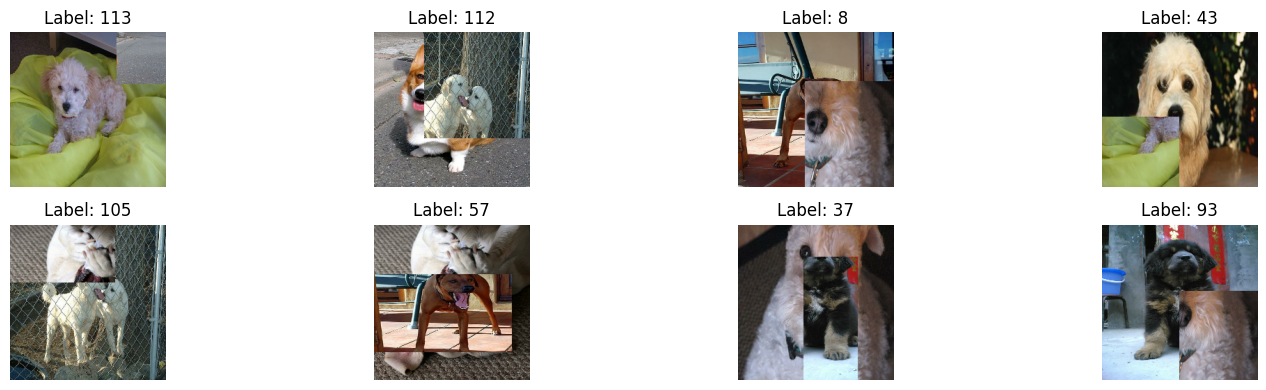

Label of first image in the batch:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.      

In [34]:
import matplotlib.pyplot as plt
# 배치 하나를 추출
for images, labels in DS_with_randomaug_train.take(1):  # 배치 하나를 가져옴
    # images는 (batch_size, height, width, channels) 형태
    # labels는 (batch_size, num_classes) 형태
    
    # 배치 내의 이미지를 그리기 위한 설정 (8개만 확인)
    fig, axes = plt.subplots(2, 4, figsize=(16, 4))  # 2x4 그리드로 이미지 표시
    axes = axes.flatten()  # 1D 배열로 변환

    # 배치 내의 이미지를 하나씩 그리기
    for i in range(len(images)): 
        ax = axes[i]
        ax.imshow(images[i])  # 이미지를 표시
        ax.axis('off')  # 축 숨기기

        # 레이블 출력 (가장 큰 값을 가지는 인덱스가 해당 이미지의 클래스)
        label = labels[i].numpy()
        class_index = np.argmax(label)  # One-hot encoding된 레이블에서 클래스 인덱스를 찾음
        ax.set_title(f'Label: {class_index}')  # 제목에 레이블을 표시

    plt.tight_layout()
    plt.show()
    # 배치의 첫 번째 이미지에 해당하는 레이블만 한 번 출력
    print("Label of first image in the batch: ", labels[0].numpy())  # 첫 번째 이미지의 레이블만 출력


In [35]:
import keras

randomaug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [36]:
EPOCH = 20

randomaug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "./best_model_ResNet50_randomaug_120dog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

history_resnet50_randomaug = randomaug_resnet50.fit(
    DS_with_randomaug_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/8),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/8),
    epochs=EPOCH,
    validation_data=DS_valid,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/20


2025-02-27 21:45:40.456183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-27 21:45:40.667133: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 21:45:42.139277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-27 21:45:42.167914: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcca01abfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 21:45:42.167946: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 21:45:42.272999: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 21:45:42.315208: I ./tensorflow/compiler/jit/device_compil

1200/1200 [==============================] - ETA: 0s - loss: 3.2628 - accuracy: 0.2760
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to ./best_model_ResNet50_randomaug_120dog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1200/1200 [==============================] - 97s 70ms/step - loss: 3.2628 - accuracy: 0.2760 - val_loss: 2.4090 - val_accuracy: 0.3750
Epoch 2/20
1200/1200 [==============================] - ETA: 0s - loss: 2.1782 - accuracy: 0.5347
Epoch 2: val_accuracy improved from 0.37500 to 0.56042, saving model to ./best_model_ResNet50_randomaug_120dog.h5
1200/1200 [==============================] - 83s 69ms/step - loss: 2.1782 - accuracy: 0.5347 - val_loss: 1.5646 - val_accuracy: 0.5604
Epoch 3/20
1200/1200 [==============================] - ETA: 0s - loss: 1.7689 - accuracy: 0.6562
Epoch 3: val_accuracy did not improve from 0.56042
1200/1200 [==============================] - 83s 69ms/step - loss: 1.7689 - accuracy: 0.6562 - val_loss: 1.6450 - val_accuracy: 0.5458
Epoch 4/20
1200/1200 [==============================] - ETA: 0s - loss: 1.5530 - accuracy: 0.7417
Epoch 4: val_accuracy did not improve from 0.56042
1200/1200 [==============================] - 82s 68ms/step - loss: 1.5530 - accuracy:

In [38]:
import json

# 학습 로그 저장
with open("./history_resnet50_randomaug.json", "w") as f:
    json.dump(history_resnet50_randomaug.history, f)

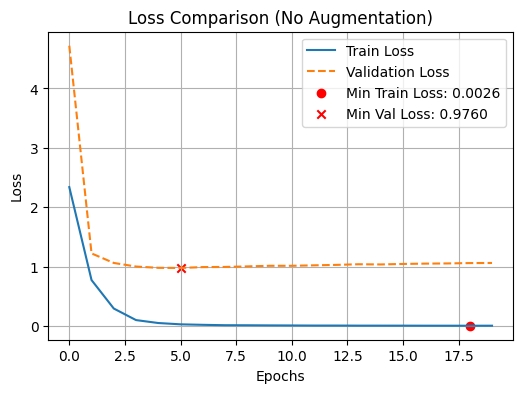

📉 No Augmentation - Min Train Loss: 0.0026 at Epoch 18
📉 No Augmentation - Min Val Loss: 0.9760 at Epoch 5



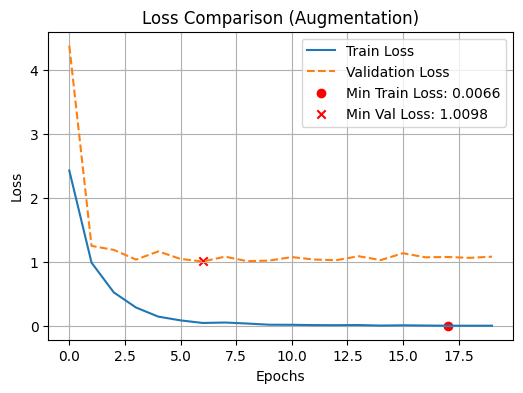

📉 Augmentation - Min Train Loss: 0.0066 at Epoch 17
📉 Augmentation - Min Val Loss: 1.0098 at Epoch 6



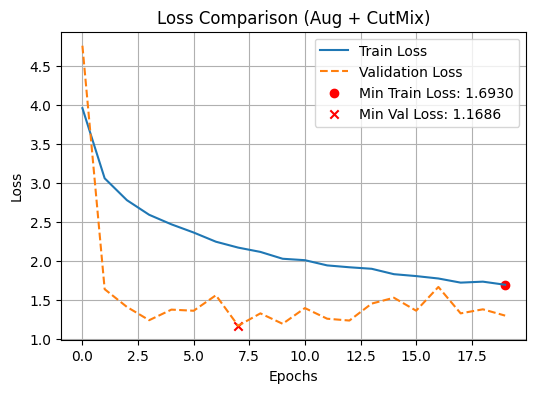

📉 Aug + CutMix - Min Train Loss: 1.6930 at Epoch 19
📉 Aug + CutMix - Min Val Loss: 1.1686 at Epoch 7



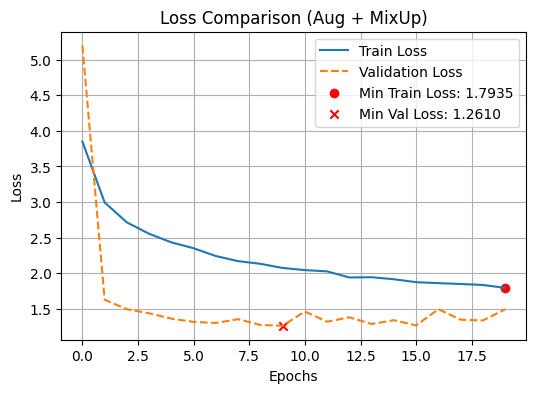

📉 Aug + MixUp - Min Train Loss: 1.7935 at Epoch 19
📉 Aug + MixUp - Min Val Loss: 1.2610 at Epoch 9



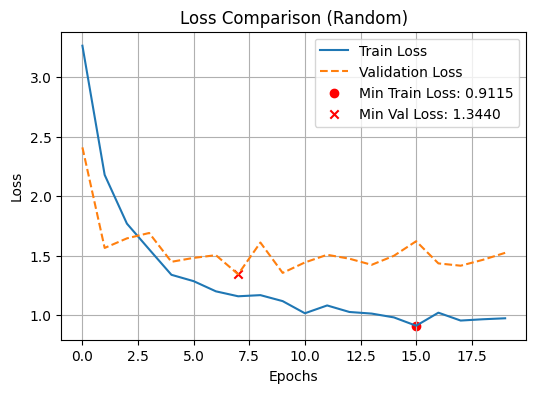

📉 Random - Min Train Loss: 0.9115 at Epoch 15
📉 Random - Min Val Loss: 1.3440 at Epoch 7



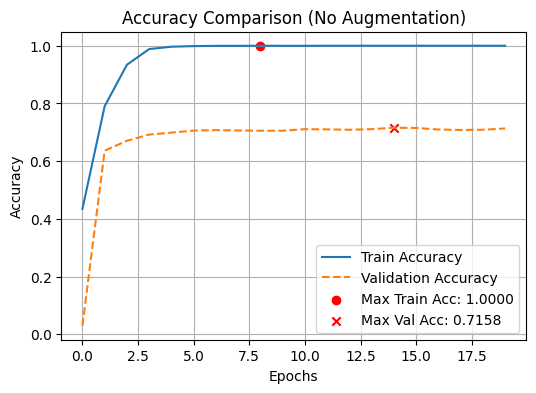

📈 No Augmentation - Max Train Accuracy: 1.0000 at Epoch 8
📈 No Augmentation - Max Val Accuracy: 0.7158 at Epoch 14



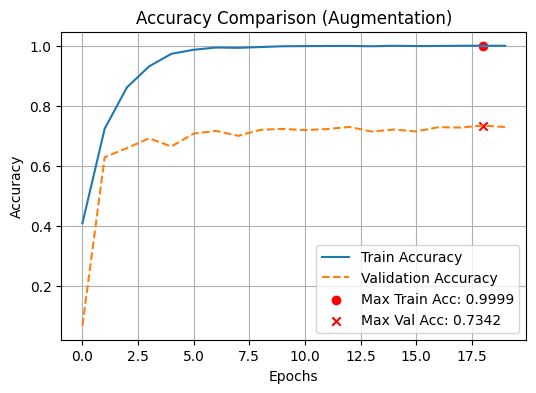

📈 Augmentation - Max Train Accuracy: 0.9999 at Epoch 18
📈 Augmentation - Max Val Accuracy: 0.7342 at Epoch 18



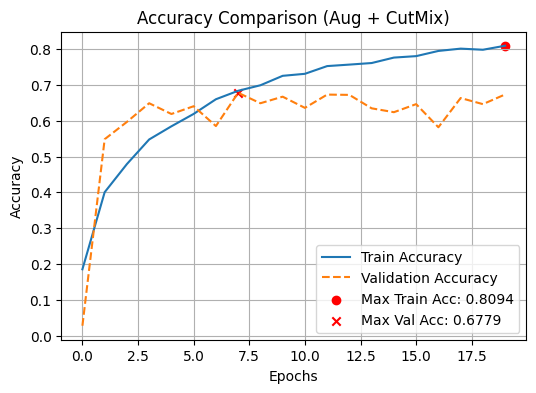

📈 Aug + CutMix - Max Train Accuracy: 0.8094 at Epoch 19
📈 Aug + CutMix - Max Val Accuracy: 0.6779 at Epoch 7



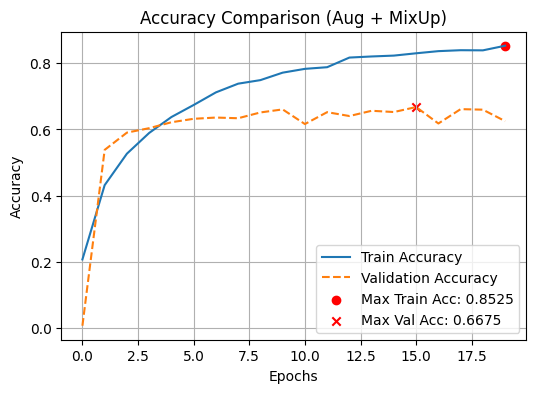

📈 Aug + MixUp - Max Train Accuracy: 0.8525 at Epoch 19
📈 Aug + MixUp - Max Val Accuracy: 0.6675 at Epoch 15



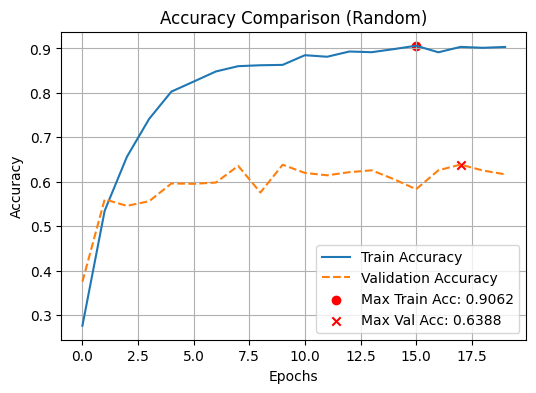

📈 Random - Max Train Accuracy: 0.9062 at Epoch 15
📈 Random - Max Val Accuracy: 0.6388 at Epoch 17


📊 Training & Validation Performance Summary
          Model  Min Train Loss  Epoch (Train Loss)  Min Val Loss  Epoch (Val Loss)  Max Train Accuracy  Epoch (Train Acc)  Max Val Accuracy  Epoch (Val Acc)
No Augmentation        0.002627                  18      0.975986                 5            1.000000                  8          0.715833               14
   Augmentation        0.006636                  17      1.009814                 6            0.999896                 18          0.734167               18
   Aug + CutMix        1.693042                  19      1.168597                 7            0.809375                 19          0.677917                7
    Aug + MixUp        1.793460                  19      1.261041                 9            0.852500                 19          0.667500               15
         Random        0.911497                  15      1.344019 

In [39]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# 📂 JSON 파일 리스트
history_files = {
    "No Augmentation": "./history_noaug_ResNet50.json",
    "Augmentation": "./history_aug_ResNet50.json",
    "Aug + CutMix": "./history_aug_cutmix_ResNet50.json",
    "Aug + MixUp": "./history_aug_mixup_ResNet50.json",
    "Random" : "./history_resnet50_randomaug.json"
}

# 결과를 저장할 리스트
results = []

# 🔹 1) 모델별 Loss 그래프 (최저 Loss 표시)
for label, file in history_files.items():
    with open(file, "r") as f:
        history = json.load(f)

    # 최저 Loss 찾기
    min_train_loss = min(history["loss"])
    min_train_epoch = history["loss"].index(min_train_loss)
    min_val_loss = min(history["val_loss"])
    min_val_epoch = history["val_loss"].index(min_val_loss)

    # 그래프 그리기
    plt.figure(figsize=(6, 4))
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], linestyle="dashed", label="Validation Loss")

    # 최저 Loss 지점 표시 (빨간 점)
    plt.scatter(min_train_epoch, min_train_loss, color="red", marker="o", label=f"Min Train Loss: {min_train_loss:.4f}")
    plt.scatter(min_val_epoch, min_val_loss, color="red", marker="x", label=f"Min Val Loss: {min_val_loss:.4f}")

    plt.title(f"Loss Comparison ({label})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    results.append({
        "Model": label,
        "Min Train Loss": min_train_loss,
        "Epoch (Train Loss)": min_train_epoch,
        "Min Val Loss": min_val_loss,
        "Epoch (Val Loss)": min_val_epoch,
        "Max Train Accuracy": None,
        "Epoch (Train Acc)": None,
        "Max Val Accuracy": None,
        "Epoch (Val Acc)": None
    })

    # 🔽 최저 Loss 출력
    print(f"📉 {label} - Min Train Loss: {min_train_loss:.4f} at Epoch {min_train_epoch}")
    print(f"📉 {label} - Min Val Loss: {min_val_loss:.4f} at Epoch {min_val_epoch}\n")

# 🔹 2) 모델별 Accuracy 그래프 (최고 Accuracy 표시)
for label, file in history_files.items():
    with open(file, "r") as f:
        history = json.load(f)

    # 최고 Accuracy 찾기
    max_train_acc = max(history["accuracy"])
    max_train_epoch = history["accuracy"].index(max_train_acc)
    max_val_acc = max(history["val_accuracy"])
    max_val_epoch = history["val_accuracy"].index(max_val_acc)

    # 그래프 그리기
    plt.figure(figsize=(6, 4))
    plt.plot(history["accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], linestyle="dashed", label="Validation Accuracy")

    # 최고 Accuracy 지점 표시 (빨간 점)
    plt.scatter(max_train_epoch, max_train_acc, color="red", marker="o", label=f"Max Train Acc: {max_train_acc:.4f}")
    plt.scatter(max_val_epoch, max_val_acc, color="red", marker="x", label=f"Max Val Acc: {max_val_acc:.4f}")

    plt.title(f"Accuracy Comparison ({label})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # results 리스트에서 해당 모델 데이터 찾기
    for result in results:
        if result["Model"] == label:
            result["Max Train Accuracy"] = max_train_acc
            result["Epoch (Train Acc)"] = max_train_epoch
            result["Max Val Accuracy"] = max_val_acc
            result["Epoch (Val Acc)"] = max_val_epoch
            break

    # 🔽 최고 Accuracy 출력
    print(f"📈 {label} - Max Train Accuracy: {max_train_acc:.4f} at Epoch {max_train_epoch}")
    print(f"📈 {label} - Max Val Accuracy: {max_val_acc:.4f} at Epoch {max_val_epoch}\n")

# 📋 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)

# 📌 표 형태로 출력
print("\n📊 Training & Validation Performance Summary")
print(df_results.to_string(index=False))


##### 최종정리 : 모델 성능 비교

| 방법                | Accuracy (%) | Validation Accuracy | 그래프 수렴 정도 |
|---------------------|--------------|---------------------|------------------|
| Augmentation        | 74.50%       | 0.734167            | 수렴             |
| No Augmentation     | 73.30%       | 0.715833            | 수렴             |
| Aug + CutMix        | 69.09%       | 0.677917            | 어느정도         |
| Aug + MixUp         | 64.74%       | 0.667500            | 어느정도         |
| Random              | 65.35%       | 0.638750            | 어느정도         |



In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# 모델 불러오기
model_random = load_model("best_model_ResNet50_randomaug_120dog.h5")

# 배치 크기 설정
BATCH_SIZE = 8

def evaluate_model(model, dataset):
    correct_predictions = 0
    total_predictions = 0

    # 데이터셋에서 배치별로 예측 수행
    for batch, labels in dataset:
        # 모델 예측
        predictions = model.predict(batch, batch_size=BATCH_SIZE)
        
        # 예측값을 확률에서 레이블로 변환
        predicted_labels = np.argmax(predictions, axis=-1)
        
        # 레이블을 정수형으로 변환 (원핫 인코딩 된 경우)
        if len(labels.shape) > 1 and labels.shape[-1] > 1:
            labels = np.argmax(labels, axis=-1)

        # 정확도 계산
        correct_predictions += np.sum(predicted_labels == labels)
        total_predictions += len(labels)
    
    # 전체 데이터에 대한 정확도 계산
    accuracy = correct_predictions / total_predictions
    return accuracy


# 각 모델에 대해 accuracy 측정
accuracy_random = evaluate_model(model_random, DS_test)

In [41]:
# 출력
print(f"Accuracy (Random): {accuracy_random * 100:.2f}%")

Accuracy (Random): 65.35%


##### 초기실험

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "./best_model_ResNet50_noaug_120dog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

history_resnet50_no_aug = resnet50.fit(
    DS_with_noaug_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=DS_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/25


2025-02-27 14:35:08.873132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-27 14:35:08.987146: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 14:35:10.890039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-27 14:35:10.922340: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff5a80923d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 14:35:10.922375: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 14:35:10.964537: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 14:35:11.000794: I ./tensorflow/compiler/jit/device_compil

375/375 [==============================] - 108s 248ms/step - loss: 2.4780 - accuracy: 0.4252 - val_loss: 5.0202 - val_accuracy: 0.0043
Epoch 2/25
375/375 [==============================] - 90s 240ms/step - loss: 0.8900 - accuracy: 0.7640 - val_loss: 3.0241 - val_accuracy: 0.2673
Epoch 3/25
375/375 [==============================] - 87s 232ms/step - loss: 0.4044 - accuracy: 0.9047 - val_loss: 1.0421 - val_accuracy: 0.6932
Epoch 4/25
375/375 [==============================] - 87s 232ms/step - loss: 0.1717 - accuracy: 0.9775 - val_loss: 0.9390 - val_accuracy: 0.7250
Epoch 5/25
375/375 [==============================] - 91s 242ms/step - loss: 0.0889 - accuracy: 0.9922 - val_loss: 0.9305 - val_accuracy: 0.7280
Epoch 6/25
375/375 [==============================] - 91s 243ms/step - loss: 0.0551 - accuracy: 0.9976 - val_loss: 0.9324 - val_accuracy: 0.7319
Epoch 7/25
375/375 [==============================] - 92s 244ms/step - loss: 0.0403 - accuracy: 0.9973 - val_loss: 0.9393 - val_accuracy: 0.

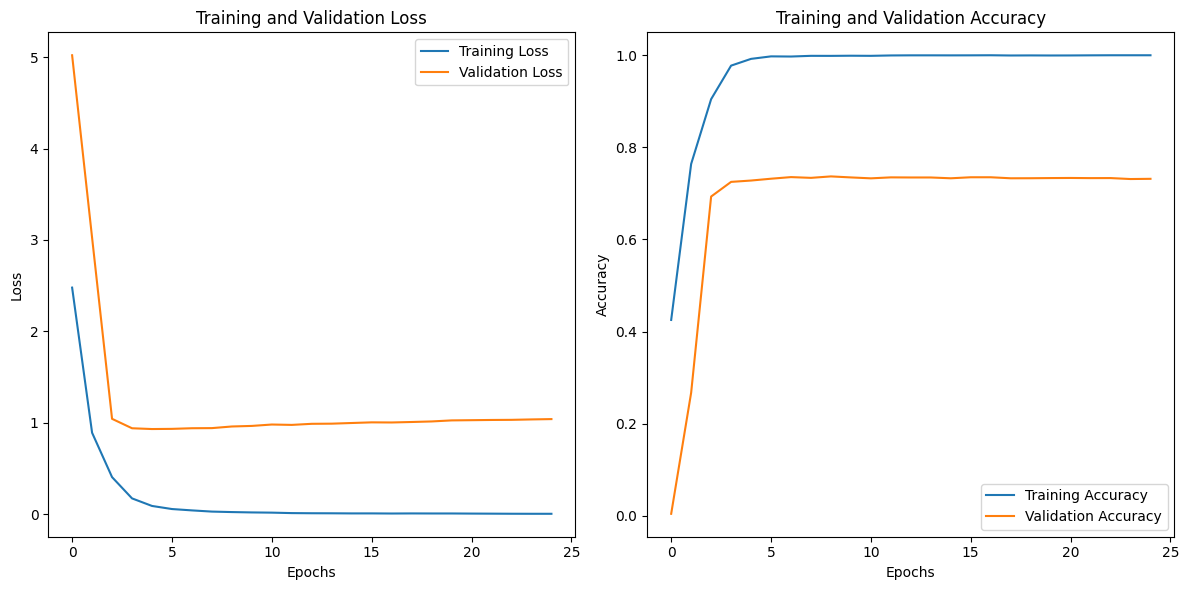

In [24]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from history
history = history_resnet50_no_aug.history

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


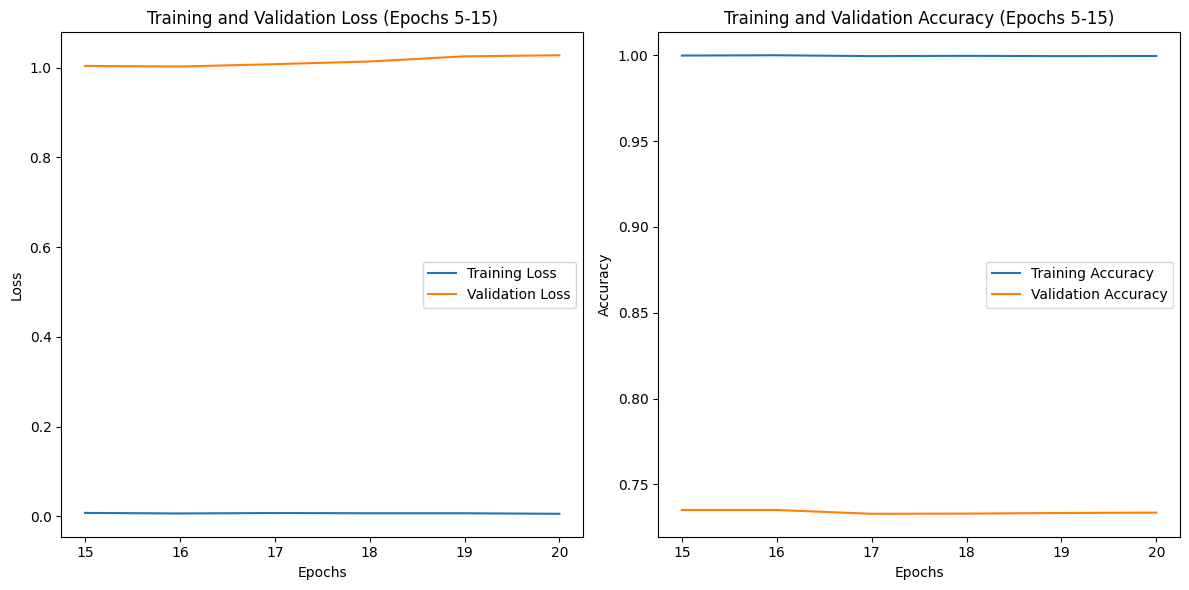

In [30]:
# Extract loss and accuracy values from history
history = history_resnet50_no_aug.history

# Define the range of epochs you want to display (5 to 15)
start_epoch = 15
end_epoch = 20

# Slice the data to only show epochs 5 to 15
epochs_range = range(start_epoch, end_epoch + 1)
loss = history['loss'][start_epoch:end_epoch+1]
val_loss = history['val_loss'][start_epoch:end_epoch+1]
accuracy = history['accuracy'][start_epoch:end_epoch+1]
val_accuracy = history['val_accuracy'][start_epoch:end_epoch+1]

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (Epochs 5-15)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Epochs 5-15)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

그래프로 분명한 지점을 잡기 힘들어 직접 계산해본 결과
validation accuracy가 차이가 나지 않기 시작하는 지점보다 하나 뒤인 13에포크까지 학습을 시켜, 증강 시 차이점을 확인해보는 것으로 결론 지었다

In [32]:
import numpy as np

# Extract loss and accuracy values from history
history = history_resnet50_no_aug.history

# Define the range of epochs you want to check (5 to 15)
start_epoch = 5
end_epoch = 15

# Slice the data to only show epochs 5 to 15
epochs_range = range(start_epoch, end_epoch + 1)
loss = history['loss'][start_epoch:end_epoch+1]
val_loss = history['val_loss'][start_epoch:end_epoch+1]
accuracy = history['accuracy'][start_epoch:end_epoch+1]
val_accuracy = history['val_accuracy'][start_epoch:end_epoch+1]

# Calculate the difference between consecutive epochs for loss and accuracy
loss_diff = np.diff(loss)
val_loss_diff = np.diff(val_loss)
accuracy_diff = np.diff(accuracy)
val_accuracy_diff = np.diff(val_accuracy)

# Define a threshold to consider the difference as minimal (e.g., 0.001)
threshold = 0.001

# Find the epochs where the validation loss is consistently increasing
increasing_val_loss_epochs = [epochs_range[i+1] for i in range(len(val_loss_diff)) if val_loss_diff[i] > 0]

# Find the epochs where accuracy stopped improving or started decreasing
stopping_epoch_loss = np.where(np.abs(loss_diff) < threshold)[0] + start_epoch + 1
stopping_epoch_val_loss = np.where(np.abs(val_loss_diff) < threshold)[0] + start_epoch + 1
stopping_epoch_accuracy = np.where(np.abs(accuracy_diff) < threshold)[0] + start_epoch + 1
stopping_epoch_val_accuracy = np.where(np.abs(val_accuracy_diff) < threshold)[0] + start_epoch + 1

# Output the results
print("Epochs where validation loss is consistently increasing:", increasing_val_loss_epochs)
print("Epoch where loss stopped improving:", stopping_epoch_loss)
print("Epoch where validation loss stopped improving:", stopping_epoch_val_loss)
print("Epoch where accuracy stopped improving:", stopping_epoch_accuracy)
print("Epoch where validation accuracy stopped improving:", stopping_epoch_val_accuracy)


Epochs where validation loss is consistently increasing: [6, 7, 8, 9, 10, 12, 13, 14, 15]
Epoch where loss stopped improving: [13 15]
Epoch where validation loss stopped improving: []
Epoch where accuracy stopped improving: [ 6  8  9 10 11 12 13 14 15]
Epoch where validation accuracy stopped improving: [12 13]


In [36]:
import json

# 학습 로그 저장
with open("./history_resnet50_no_aug.json", "w") as f:
    json.dump(history_resnet50_no_aug.history, f)

In [37]:
EPOCH = 13

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

kernel이 outofmemory가 떠서 배치를 16으로 감소 / augmented를 적용시키면 메모리 사용량이 증가하는 것을 확인

In [ ]:
checkpoint_path = "./best_model_ResNet50_aug_120dog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

history_resnet50_aug = aug_resnet50.fit(
    DS_with_noaug_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=DS_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/13


: 

In [ ]:
EPOCH = 13

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history_resnet50_aug = aug_resnet50.fit(
    DS_with_aug_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=DS_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/13


2025-02-27 15:56:16.375243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-27 15:56:16.598435: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 15:56:18.384955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-27 15:56:18.419313: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb7ea5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 15:56:18.419348: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 15:56:18.537861: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-27 15:56:18.585016: I ./tensorflow/compiler/jit/device_compiler.h:

750/750 [==============================] - 117s 138ms/step - loss: 2.2835 - accuracy: 0.4353 - val_loss: 2.9826 - val_accuracy: 0.2608
Epoch 2/13
750/750 [==============================] - 104s 138ms/step - loss: 0.9393 - accuracy: 0.7305 - val_loss: 1.1524 - val_accuracy: 0.6589
Epoch 3/13
750/750 [==============================] - 103s 138ms/step - loss: 0.4772 - accuracy: 0.8706 - val_loss: 1.0240 - val_accuracy: 0.6972
Epoch 4/13
750/750 [==============================] - 103s 138ms/step - loss: 0.3033 - accuracy: 0.9235 - val_loss: 1.0219 - val_accuracy: 0.7028
Epoch 5/13
750/750 [==============================] - 104s 139ms/step - loss: 0.1441 - accuracy: 0.9711 - val_loss: 1.0365 - val_accuracy: 0.7134
Epoch 6/13
750/750 [==============================] - 103s 137ms/step - loss: 0.0698 - accuracy: 0.9912 - val_loss: 0.9349 - val_accuracy: 0.7358
Epoch 7/13
750/750 [==============================] - 102s 137ms/step - loss: 0.0421 - accuracy: 0.9952 - val_loss: 0.9351 - val_accura

그래프를 확인해보니 20 epoch를 기준으로 학습시키고 train, vaild, test로 나누며 checkpoint 저장하며 batch크기를 16으로 고정하여 처음부터 끝까지 학습을 돌리고 평가하기로 판단

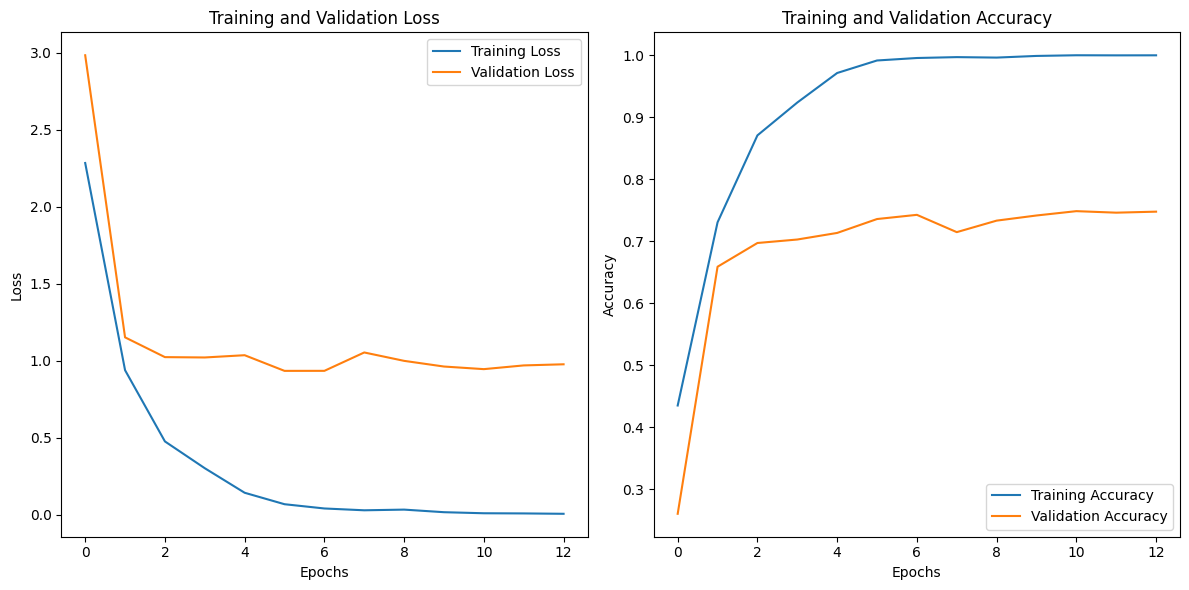

In [26]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from history
history = history_resnet50_aug.history

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##### 최종정리 : 모델 성능 비교

| 방법                | Accuracy (%) | Validation Accuracy | 그래프 수렴 정도 |
|---------------------|--------------|---------------------|------------------|
| Augmentation        | 74.50%       | 0.734167            | 수렴             |
| No Augmentation     | 73.30%       | 0.715833            | 수렴             |
| Aug + CutMix        | 69.09%       | 0.677917            | 어느정도         |
| Aug + MixUp         | 64.74%       | 0.667500            | 어느정도         |
| Random              | 65.35%       | 0.638750            | 어느정도         |

